## Importing

In [1]:
from typing import TypeVar, Dict, Tuple, Any, Union, Iterable, Optional, Sequence
from pprint import PrettyPrinter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.exceptions import NotFittedError
import torch
import transformers
from transformers import logging
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tqdm import notebook
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 12345
N_ITER = 5
CV_FOLDS = 2
DATA_SIZE = 1000
MAX_LENGTH = 512
F1_SCORE_THRESHOLD = 0.75
ROC_AUC_THRESHOLD = 0.5
TRAIN_SET_SIZE = 0.75
ENABLE_PARALLELIZATION = False
SCORER = "f1"
VERBOSITY = 5
BATCH_SIZE = 10

In [2]:
# Using all processors
N_JOBS = -1 if ENABLE_PARALLELIZATION else None

# Visual theme for plots
sns.set_theme()

# Ignoring warnings when defining a pretrained transformers model
logging.set_verbosity_error()

# Defining a cross-validator
KF = KFold(n_splits=CV_FOLDS, random_state=RANDOM_STATE, shuffle=True)

# Setting printing behavior
pp = PrettyPrinter(depth=4)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

# Printing details of GPU device
if device.type == "cuda":
    gpu_device_name = torch.cuda.get_device_name(0)
    gpu_memory_alloc_GB = torch.cuda.memory_allocated(0) / 1024**3
    gpu_memory_cached_GB = torch.cuda.memory_reserved(0) / 1024**3

    print(f"Device name: {gpu_device_name}")
    print(f"Memory allocated: {np.round(gpu_memory_alloc_GB, 1)} GB")
    print(f"Memory cached: {np.round(gpu_memory_cached_GB, 1)} GB")

Using device: cpu


**Summary**

In this small section, we have collected all the libraries and utilities that we will use during the process of completing the project. In particular, we defined a number of constants to achieve code flexibility, imported a number of libraries for gradient boosting and machine learning as well as transformers, and also added the opportunity to execute the code on *GPU*.

## Uploading data

In [4]:
toxic_comments_df = pd.read_csv(
    "toxic_comments.csv", usecols=["text", "toxic"], header=0
)
toxic_comments_df.sample(5, random_state=RANDOM_STATE)

,text,toxic
109486,Expert Categorizers \n\nWhy is there no menti...,0
104980,"""\n\n Noise \n\nfart* talk. """,1
82166,"An indefinite block is appropriate, even for a...",0
18721,I don't understand why we have a screenshot of...,0
128178,"Hello! Some of the people, places or things yo...",0


We can see that the data we have uploaded contains the following information.

<table>
<thead>
<tr><th>Column</th><th>Description</th></tr>
</thead>
<tbody>
    <tr><td><code>text</code></td><td><i>Text of a commentary</i></td></tr>
<tr><td><code>toxic</code></td><td><i>Indicator of the toxicity of a commentary</i></td></tr>
</tbody>
</table>

We observe that the data consists of some comments, which are assigned toxicity values of zero (positive comment) or one (negative comment). Let's display more detailed information about the data.

In [5]:
toxic_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


**Summary**

At this stage, we were able to study the data that was provided to us, as a result of which we found out that the objects in the dataset represent texts of commentaries along with a binary indicator of its toxicity. Furthermore, there are no missing values in the data.

## Data preparation

### Class balance and sampling

Since the task we are going to solve here is classification, let's first look at the balance of classes.

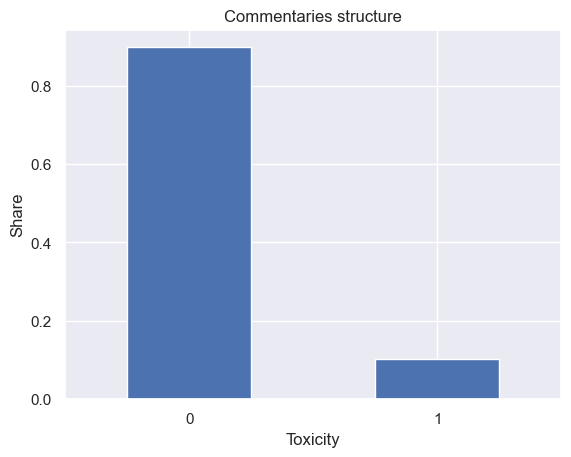

0    0.898388
1    0.101612
Name: toxic, dtype: float64

In [6]:
toxic_comments_df["toxic"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Toxicity",
    ylabel="Share",
    title="Commentaries structure",
)
plt.xticks(rotation=0)
plt.show()

toxic_comments_df["toxic"].value_counts(normalize=True)

We notice quite a strong class imbalance that may lead to poor learning performance. We will deal with this problem later. For now, the next step is to tokenize data and then use the tokenized data to create embeddings. However, it will be extremely time-consuming and computationally expensive to preprocess all 159,292 commentaries. Hence, let's choose a subset of them. 

In [7]:
toxic_df = toxic_comments_df.sample(DATA_SIZE, random_state=RANDOM_STATE).reset_index(
    drop=True
)
toxic_num = toxic_df["toxic"].value_counts()
toxic_num.name = "comm_num"
toxic_share = toxic_df["toxic"].value_counts(normalize=True)
toxic_share.name = "comm_share"
toxic_balance = pd.concat([toxic_num, toxic_share], axis=1)
toxic_balance

,comm_num,comm_share
0,890,0.89
1,110,0.11


We chose 1000 randomly sampled observations and see that the balance of classes stayed approximately the same.

### Encoding

#### Tokenization

In [8]:
# Defining a tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("unitary/toxic-bert")

# Tokenizing data
data_tokenized = toxic_df["text"].apply(
    lambda x: tokenizer.encode(
        x,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        truncation=True,
        padding="max_length",
    )
)

# Type conversion
data_padded = np.array([i for i in data_tokenized.values])

# Creating attention mask
attention_mask = np.where(data_padded != 0, 1, 0)

In [9]:
print(f"Tokenized (padded) data dimensions: {data_padded.shape}")
print(f"Attention mask dimensions: {attention_mask.shape}")

Tokenized (padded) data dimensions: (1000, 512)
Attention mask dimensions: (1000, 512)


We see that we got the desired dimensions of the matrices for tokenized data and attention mask. 

#### Features extraction (embeddings)

The next logical step is to recover the features from the tokenized data (embeddings). Firstly, let's load the model from `unitary/toxic-bert` and add `to(device)` in order to allow for using *GPU*.

**Warning:** *Loading the model in the following cell may take approximately <u>8 minutes</u> on CPU.*

In [10]:
model = transformers.AutoModel.from_pretrained("unitary/toxic-bert").to(device)

Next, we launch the process of creating embeddings in batches which can also be executed on *GPU*.

**Warning:** *The embedding creation process in the following cell may take approximately <u>40 minutes</u> to run on CPU.*

In [11]:
# Features extraction (embeddings)
batch_size = BATCH_SIZE
embeddings = []
for i in notebook.tqdm(range(data_padded.shape[0] // batch_size)):
    batch = torch.LongTensor(data_padded[batch_size * i : batch_size * (i + 1)]).to(device)
    attention_mask_batch = torch.LongTensor(
        attention_mask[batch_size * i : batch_size * (i + 1)]
    ).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
print(f"Batch size: {batch_size}")
print(f"Number of batches: {len(embeddings)}")
print(f"Emdeddings dimensions per batch: {embeddings[0].shape}")
print(f"Number of objects in data: {data_padded.shape[0]}")

Batch size: 10
Number of batches: 100
Emdeddings dimensions per batch: (10, 768)
Number of objects in data: 1000


#### Data split

Now we can just concatenate all embeddings into one features matrix.

In [13]:
features = np.concatenate(embeddings)
target = toxic_df['toxic']

print(f"Features matrix dimensions: {features.shape}")
print(f"Target vector length: {target.shape}")

Features matrix dimensions: (1000, 768)
Target vector length: (1000,)


We then split the data into training and test set, at the same time preserving the proportions of classes in `target` by using `stratify=target`.

In [14]:
target.value_counts(normalize=True)

0    0.89
1    0.11
Name: toxic, dtype: float64

In [15]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=TRAIN_SET_SIZE, random_state=RANDOM_STATE, stratify=target
)

print(f"Features matrix dimensions (train): {features_train.shape}")
print(f"Target vector length (train): {target_train.shape}\n")
print(f"Features matrix dimensions (test): {features_test.shape}")
print(f"Target vector length (test): {target_test.shape}")

Features matrix dimensions (train): (750, 768)
Target vector length (train): (750,)

Features matrix dimensions (test): (250, 768)
Target vector length (test): (250,)


In [16]:
target_train.value_counts(normalize=True)

0    0.889333
1    0.110667
Name: toxic, dtype: float64

In [17]:
target_test.value_counts(normalize=True)

0    0.892
1    0.108
Name: toxic, dtype: float64

Later, in addition to usual models, we will implement `AutoModelForSequenceClassification` for which it suffices to just provide the original text of a commentary. Hence, we should also split the data here, preserving only the test set.

In [18]:
features_text = toxic_df['text']
_, test_text, _, _ = train_test_split(
    features_text, target, train_size=TRAIN_SET_SIZE, random_state=RANDOM_STATE, stratify=target
)

**Summary**

This stage was aimed at encoding the dataset with commentaries in order to enable models to make predictions. The data has been tokenized which was later used for features extraction using embeddings. Lastly, we split the data.

## Hyperparameter tuning

### Preparation for tuning

Now, we can start preparing for hyperparameter tuning. Here, we will write a function called `prepare_tuning()` where we can pass the model as well as some keyword parameters signifying what hyperparameters and what values we would like to consider in the grid search.

In [19]:
# Defining new types
Model = TypeVar("Model")
ImblearnPipeline = TypeVar("ImblearnPipeline")
HyperparamsGrid = Dict[str, Sequence[Any]]


def prepare_tuning(
    model: Model, **tuning_params: Sequence[Any]
) -> Tuple[ImblearnPipeline, HyperparamsGrid]:
    """Makes preparations for grid search.
    
    Creates an Imbalanced-Learn Pipeline using
    SMOTE and model as steps. Additionally, creates
    a parameter grid as a dict with keys names prefixed 
    by the alias of the last estimator in the Pipeline created.
    
    Args:
        model: 
            Class implementing estimators from Scikit-Learn 
            or Gradient Boosting libraries.
        **tuning_params:
            Keyword arguments used to create a grid
            of hyperparameters.
    
    Returns: 
        ImblearnPipeline object and HyperparamsGrid object 
        mapping hyperparameter names to the values to consider in
        grid search.
    """
    # Creating Imblearn's Pipeline
    upsampler = SMOTE(random_state=RANDOM_STATE)
    pipeline = make_imb_pipeline(upsampler, model)
    # Creating a parameter grid with alias-prefixed keys
    step_names = (*pipeline.named_steps,)
    grid = {
        step_names[-1] + "__" + param: tuning_params[param] for param in tuning_params
    }

    return pipeline, grid

Next, in order to simplify the code and avoiding dublicating, we will write a wrapper for `RandomizedSearchCV` which we will call `RandomizedClassificationHyperopt`. It will enable us not just to train several models and choose the best one, but also compute some classification metrics for evaluation dataset (`eval_dataset`). Additionally, we can also plot a confusion matrix quite easily.

In [20]:
class RandomizedClassificationHyperopt(RandomizedSearchCV):
    """Wrapper for RandomizedSearchCV with custom defaults 
    and additional functionality.
    """

    def __init__(
        self,
        estimator: Union[ImblearnPipeline, Model],
        param_distributions: HyperparamsGrid,
        train_dataset: Tuple[Any, Any],
        eval_dataset: Tuple[Any, Any],
        cv: Iterable[Any] = KF,
        random_state: int = RANDOM_STATE,
        scoring: str = SCORER,
        n_iter: int = N_ITER,
        n_jobs: Optional[int] = N_JOBS,
        verbose: int = VERBOSITY,
        return_train_score: bool = True,
        **kwargs: Any,
    ) -> None:
        super().__init__(
            estimator,
            param_distributions,
            cv=KF,
            random_state=RANDOM_STATE,
            scoring=SCORER,
            n_iter=N_ITER,
            n_jobs=N_JOBS,
            verbose=VERBOSITY,
            return_train_score=True,
            **kwargs,
        )
        train_features, train_target = train_dataset
        eval_features, eval_target = eval_dataset
        self.train_features = train_features
        self.train_target = train_target
        self.eval_features = eval_features
        self.eval_target = eval_target

    def train_crossvalidate(self) -> None:
        """Launches grid search with cross-validation."""
        self.fit(self.train_features, self.train_target)
        print("Fitting done")

    def compute_classification_stats(
        self, metric: Optional[str] = None
    ) -> Optional[float]:
        """Computes classification statistics for evaluation
        data and either prints all metrics at ones or returns 
        the value of a particular metric.
        """
        # Checking if the model has been fit
        try:
            self.eval_predictions = self.predict(self.eval_features)
        except NotFittedError:
            not_fitted_error_msg = (
                f"The {type(self).__name__} instance has not been fitted yet.\n"
                "Call 'train_crossvalidate' before using this estimator."
            )
            print(not_fitted_error_msg)
        # Proceed if exception has not been raised
        else:
            target_names = ["positive", "toxic"]
            # Return the value of a particular metric
            if metric is not None:
                # Adding ROC-AUC to metric values to be returned
                if metric == "roc-auc":
                    return roc_auc_score(
                        self.eval_target, self.predict_proba(self.eval_features)[:, 1]
                    )
                # Return some other value of metrics contained in classification_report
                else:
                    classification_stats = classification_report(
                        self.eval_target,
                        self.eval_predictions,
                        target_names=target_names,
                        output_dict=True,
                    )
                    return classification_stats["toxic"][metric]
            # Print out a summary of all classification metrics if metric=None
            classification_stats = classification_report(
                self.eval_target, self.eval_predictions, target_names=target_names
            )
            print(classification_stats)

    def plot_confusion_matrix(self) -> None:
        """Plots confusion matrix for the best estimator."""
        try:
            self.eval_predictions = self.predict(self.eval_features)
        except NotFittedError:
            not_fitted_error_msg = (
                f"The {type(self).__name__} instance has not been fitted yet.\n"
                "Call 'train_crossvalidate' before using this estimator."
            )
            print(not_fitted_error_msg)
        # Plot the confusion matrix if the exception has not been raised
        else:
            sns.reset_defaults()
            disp = ConfusionMatrixDisplay.from_predictions(
                self.eval_target,
                self.eval_predictions,
                cmap=plt.cm.Blues,
                display_labels=["Positive", "Toxic"],
            )
            model_name = type(
                self.best_estimator_.named_steps[
                    (*self.best_estimator_.named_steps,)[1]
                ]
            ).__name__
            plt.title(f"Confusion matrix ({model_name})")
            plt.tight_layout()
            plt.show()

In [21]:
# Outputing class methods written above
for key, value in RandomizedClassificationHyperopt.__dict__.items():
    if "function" in str(value):
        print(key)

__doc__
__init__
train_crossvalidate
compute_classification_stats
plot_confusion_matrix


All in all, apart from common `__doc__` and `__init__` attributes, we have written three additional methods:

* `train_crossvalidate()` => a wrapper for `fit()` method;
* `compute_classification_stats()` => computation of key classification metrics;
* `plot_confusion_matrix()` => plotting confusion matrix.

### Grid search

We will consider 3 machine learning models and 3 gradient boosting models. In addition, we will experiment with the transformer for direct text classification. Hence, the following models will be considered:

1. `DecisionTreeClassifier`
2. `RandomForestClassifier`
3. `KNeighborsClassifier`
4. `CatBoostClassifier`
5. `XGBClassifier`
6. `LGBMClassifier`
7. `AutoModelForSequenceClassification`

#### `DecisionTree`

In [22]:
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_pipeline, dt_grid = prepare_tuning(model=dt_model, max_depth=np.arange(1, 10))
pp.pprint(dt_grid)

{'decisiontreeclassifier__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}


In [23]:
dt_grid_search = RandomizedClassificationHyperopt(
    estimator=dt_pipeline,
    param_distributions=dt_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
)
dt_grid_search.train_crossvalidate()

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END decisiontreeclassifier__max_depth=4;, score=(train=1.000, test=0.877) total time=   0.1s
[CV 2/2] END decisiontreeclassifier__max_depth=4;, score=(train=1.000, test=0.897) total time=   0.1s
[CV 1/2] END decisiontreeclassifier__max_depth=1;, score=(train=0.947, test=0.897) total time=   0.0s
[CV 2/2] END decisiontreeclassifier__max_depth=1;, score=(train=0.938, test=0.869) total time=   0.0s
[CV 1/2] END decisiontreeclassifier__max_depth=9;, score=(train=1.000, test=0.877) total time=   0.1s
[CV 2/2] END decisiontreeclassifier__max_depth=9;, score=(train=1.000, test=0.897) total time=   0.1s
[CV 1/2] END decisiontreeclassifier__max_depth=7;, score=(train=1.000, test=0.877) total time=   0.1s
[CV 2/2] END decisiontreeclassifier__max_depth=7;, score=(train=1.000, test=0.897) total time=   0.1s
[CV 1/2] END decisiontreeclassifier__max_depth=5;, score=(train=1.000, test=0.877) total time=   0.1s
[CV 2/2] END decisiont

#### `RandomForest`

In [24]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_pipeline, rf_grid = prepare_tuning(model=rf_model, max_depth=np.arange(1, 5), n_estimators=np.arange(10, 100, 10))
pp.pprint(rf_grid)

{'randomforestclassifier__max_depth': array([1, 2, 3, 4]),
 'randomforestclassifier__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [25]:
rf_grid_search = RandomizedClassificationHyperopt(
    estimator=rf_pipeline,
    param_distributions=rf_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
)
rf_grid_search.train_crossvalidate()

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=60;, score=(train=0.918, test=0.927) total time=   0.2s
[CV 2/2] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=60;, score=(train=0.927, test=0.889) total time=   0.2s
[CV 1/2] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=30;, score=(train=0.947, test=0.927) total time=   0.1s
[CV 2/2] END randomforestclassifier__max_depth=1, randomforestclassifier__n_estimators=30;, score=(train=0.927, test=0.898) total time=   0.1s
[CV 1/2] END randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=40;, score=(train=1.000, test=0.935) total time=   0.2s
[CV 2/2] END randomforestclassifier__max_depth=3, randomforestclassifier__n_estimators=40;, score=(train=0.962, test=0.936) total time=   0.2s
[CV 1/2] END randomforestclassifier__max_depth=3, randomforestclassifier__n_estima

#### `KNN`

In [26]:
knn_model = KNeighborsClassifier()
knn_pipeline, knn_grid = prepare_tuning(
    model=knn_model, n_neighbors=np.arange(2, 9), weights=["uniform", "distance"]
)
pp.pprint(knn_grid)

{'kneighborsclassifier__n_neighbors': array([2, 3, 4, 5, 6, 7, 8]),
 'kneighborsclassifier__weights': ['uniform', 'distance']}


In [27]:
knn_grid_search = RandomizedClassificationHyperopt(
    estimator=knn_pipeline,
    param_distributions=knn_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
)
knn_grid_search.train_crossvalidate()

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END kneighborsclassifier__n_neighbors=2, kneighborsclassifier__weights=uniform;, score=(train=1.000, test=0.909) total time=   0.0s
[CV 2/2] END kneighborsclassifier__n_neighbors=2, kneighborsclassifier__weights=uniform;, score=(train=1.000, test=0.926) total time=   0.0s
[CV 1/2] END kneighborsclassifier__n_neighbors=7, kneighborsclassifier__weights=uniform;, score=(train=0.900, test=0.900) total time=   0.0s
[CV 2/2] END kneighborsclassifier__n_neighbors=7, kneighborsclassifier__weights=uniform;, score=(train=0.905, test=0.889) total time=   0.0s
[CV 1/2] END kneighborsclassifier__n_neighbors=5, kneighborsclassifier__weights=distance;, score=(train=1.000, test=0.911) total time=   0.0s
[CV 2/2] END kneighborsclassifier__n_neighbors=5, kneighborsclassifier__weights=distance;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 1/2] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance;, s

#### `CatBoost`

In [28]:
cb_model = CatBoostClassifier(verbose=0)
cb_pipeline, cb_grid = prepare_tuning(
    model=cb_model,
    max_depth=np.arange(1, 5),
    n_estimators=np.arange(10, 100, 10),
    learning_rate=np.arange(0.1, 1.0, 0.1),
)
pp.pprint(cb_grid)

{'catboostclassifier__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'catboostclassifier__max_depth': array([1, 2, 3, 4]),
 'catboostclassifier__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [29]:
cb_grid_search = RandomizedClassificationHyperopt(
    estimator=cb_pipeline,
    param_distributions=cb_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
)
cb_grid_search.train_crossvalidate()

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END catboostclassifier__learning_rate=0.8, catboostclassifier__max_depth=2, catboostclassifier__n_estimators=40;, score=(train=1.000, test=0.843) total time=   1.0s
[CV 2/2] END catboostclassifier__learning_rate=0.8, catboostclassifier__max_depth=2, catboostclassifier__n_estimators=40;, score=(train=1.000, test=0.876) total time=   0.7s
[CV 1/2] END catboostclassifier__learning_rate=0.6, catboostclassifier__max_depth=1, catboostclassifier__n_estimators=20;, score=(train=1.000, test=0.833) total time=   0.3s
[CV 2/2] END catboostclassifier__learning_rate=0.6, catboostclassifier__max_depth=1, catboostclassifier__n_estimators=20;, score=(train=1.000, test=0.920) total time=   0.2s
[CV 1/2] END catboostclassifier__learning_rate=0.1, catboostclassifier__max_depth=4, catboostclassifier__n_estimators=70;, score=(train=1.000, test=0.925) total time=   3.3s
[CV 2/2] END catboostclassifier__learning_rate=0.1, catboostclassifier

#### `XGBoost`

In [30]:
xgb_model = XGBClassifier()
xgb_pipeline, xgb_grid = prepare_tuning(
    model=xgb_model,
    max_depth=np.arange(1, 5),
    n_estimators=np.arange(10, 100, 10),
    learning_rate=np.arange(0.1, 1.0, 0.1),
)
pp.pprint(xgb_grid)

{'xgbclassifier__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'xgbclassifier__max_depth': array([1, 2, 3, 4]),
 'xgbclassifier__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [31]:
xgb_grid_search = RandomizedClassificationHyperopt(
    estimator=xgb_pipeline,
    param_distributions=xgb_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
)
xgb_grid_search.train_crossvalidate()

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END xgbclassifier__learning_rate=0.8, xgbclassifier__max_depth=2, xgbclassifier__n_estimators=40;, score=(train=1.000, test=0.921) total time=   0.1s
[CV 2/2] END xgbclassifier__learning_rate=0.8, xgbclassifier__max_depth=2, xgbclassifier__n_estimators=40;, score=(train=1.000, test=0.923) total time=   0.1s
[CV 1/2] END xgbclassifier__learning_rate=0.6, xgbclassifier__max_depth=1, xgbclassifier__n_estimators=20;, score=(train=1.000, test=0.909) total time=   0.1s
[CV 2/2] END xgbclassifier__learning_rate=0.6, xgbclassifier__max_depth=1, xgbclassifier__n_estimators=20;, score=(train=1.000, test=0.925) total time=   0.1s
[CV 1/2] END xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=70;, score=(train=1.000, test=0.909) total time=   0.9s
[CV 2/2] END xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=4, xgbclassifier__n_estimators=70;, score=(train=1.000, test=0.915) total

#### `LightGBM`

In [32]:
lgbm_model = LGBMClassifier()
lgbm_pipeline, lgbm_grid = prepare_tuning(
    model=lgbm_model,
    max_depth=np.arange(1, 6),
    n_estimators=np.arange(10, 100, 10),
    learning_rate=np.arange(0.1, 1.0, 0.1),
)
pp.pprint(lgbm_grid)

{'lgbmclassifier__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'lgbmclassifier__max_depth': array([1, 2, 3, 4, 5]),
 'lgbmclassifier__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [33]:
lgbm_grid_search = RandomizedClassificationHyperopt(
    estimator=lgbm_pipeline,
    param_distributions=lgbm_grid,
    train_dataset=(features_train, target_train),
    eval_dataset=(features_test, target_test),
)
lgbm_grid_search.train_crossvalidate()

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END lgbmclassifier__learning_rate=0.2, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=70;, score=(train=1.000, test=0.897) total time=   0.7s
[CV 2/2] END lgbmclassifier__learning_rate=0.2, lgbmclassifier__max_depth=5, lgbmclassifier__n_estimators=70;, score=(train=1.000, test=0.897) total time=   0.5s
[CV 1/2] END lgbmclassifier__learning_rate=0.5, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=30;, score=(train=1.000, test=0.857) total time=   0.2s
[CV 2/2] END lgbmclassifier__learning_rate=0.5, lgbmclassifier__max_depth=4, lgbmclassifier__n_estimators=30;, score=(train=1.000, test=0.897) total time=   0.3s
[CV 1/2] END lgbmclassifier__learning_rate=0.5, lgbmclassifier__max_depth=2, lgbmclassifier__n_estimators=20;, score=(train=1.000, test=0.872) total time=   0.1s
[CV 2/2] END lgbmclassifier__learning_rate=0.5, lgbmclassifier__max_depth=2, lgbmclassifier__n_estimators=20;, score=(train=1.000,

#### `SequenceClassification`

In [34]:
model_path = "martin-ha/toxic-comment-model"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_path)
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_path)

text_pipeline = transformers.TextClassificationPipeline(
    model=model, tokenizer=tokenizer
)

predictions_text = []
for text in notebook.tqdm(test_text):
    prediction_text = text_pipeline(text[:MAX_LENGTH])
    predictions_text.append(1 if prediction_text[0]["label"] == "toxic" else 0)

text_classification_f1_score = f1_score(target_test, predictions_text)

  0%|          | 0/250 [00:00<?, ?it/s]

**Summary**

In this section, we have trained a number of different models with different hyperparameters.

## Models analysis

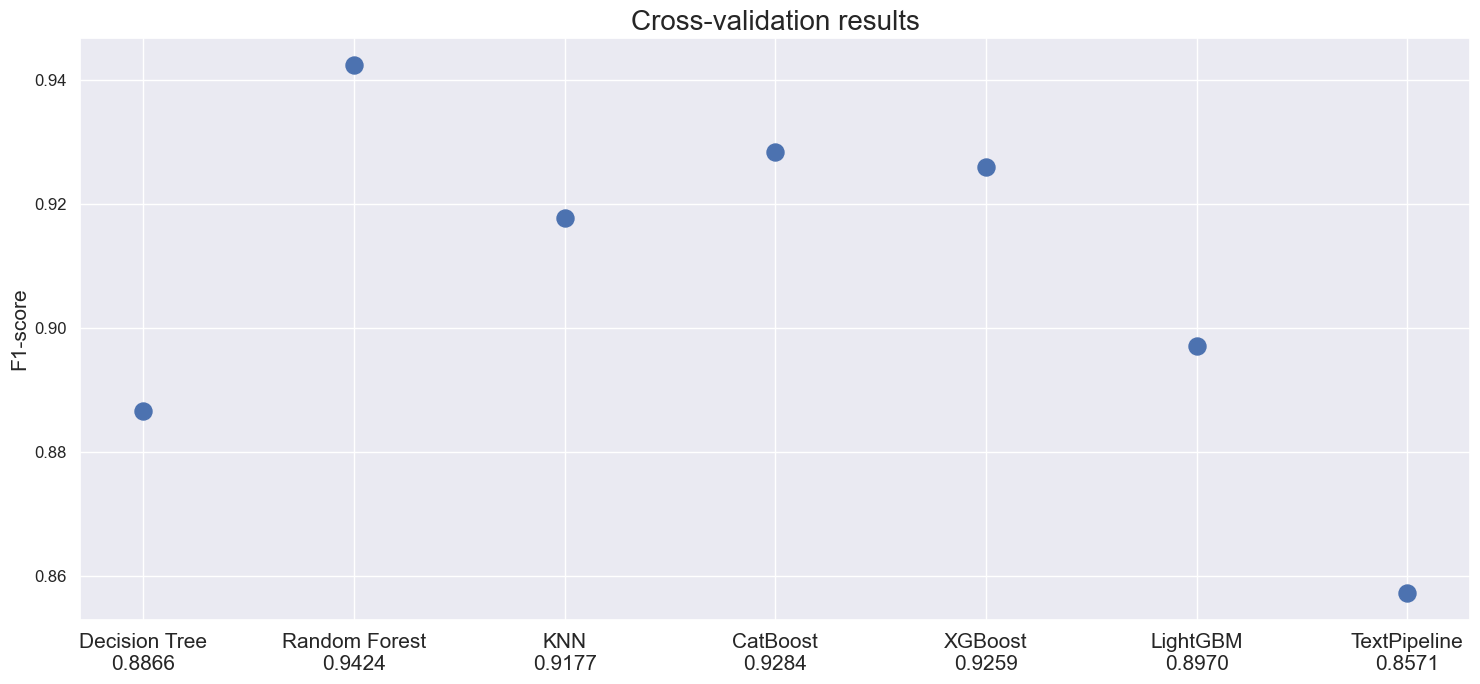

In [35]:
results = [
    ("Decision Tree", dt_grid_search.best_score_),
    ("Random Forest", rf_grid_search.best_score_),
    ("KNN", knn_grid_search.best_score_),
    ("CatBoost", cb_grid_search.best_score_),
    ("XGBoost", xgb_grid_search.best_score_),
    ("LightGBM", lgbm_grid_search.best_score_),
    ("TextPipeline", text_classification_f1_score),
]

names, scores = zip(*results)
names_with_scores = ["%s\n%.4f" % (name, loss) for name, loss in results]

plt.figure(figsize=(15, 7))
plt.scatter(range(len(results)), scores, s=150)
plt.xticks(range(len(results)), names_with_scores, fontsize=15)
plt.yticks(fontsize=12)
plt.title("Cross-validation results", fontsize=20)
plt.ylabel("F1-score", fontsize=15)
plt.tight_layout()
plt.show()

## Quality and sanity check

In [36]:
# Selecting the optimal model
final_model = rf_grid_search

In [37]:
# Computing classification statistics
final_model_f1_score = final_model.compute_classification_stats(metric="f1-score")
final_model_roc_auc = final_model.compute_classification_stats(metric="roc-auc")
final_model_recall = final_model.compute_classification_stats(metric="recall")
final_model_precision = final_model.compute_classification_stats(metric="precision")

# Fitting dummy model
dummy_model = DummyClassifier(strategy="constant", constant=1)
dummy_model.fit(features_train, target_train)
dummy_predictions = dummy_model.predict(features_test)
dummy_model_f1_score = f1_score(target_test, dummy_predictions)

# Quality check
assert (
    final_model_f1_score >= F1_SCORE_THRESHOLD
), "The model performance is unsatisfactory"
print("QUALITY CHECK: PASSED")

# Sanity check
assert (final_model_roc_auc > ROC_AUC_THRESHOLD) & (
    final_model_f1_score > dummy_model_f1_score
), "The model is inadequate"
print("SANITY CHECK: PASSED")

QUALITY CHECK: PASSED
SANITY CHECK: PASSED


## Final model analysis

### Classification statistics

In [38]:
final_model.compute_classification_stats()
print(f"Hyperparameters: {final_model.best_params_}")
print(f"F1-score: {final_model_f1_score:.4f}")
print(f"ROC_AUC: {final_model_roc_auc:.4f}")
print(f"Recall: {final_model_recall:.4f}")
print(f"Precision: {final_model_precision:.4f}")

              precision    recall  f1-score   support

    positive       1.00      1.00      1.00       223
       toxic       0.96      0.96      0.96        27

    accuracy                           0.99       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.99      0.99      0.99       250

Hyperparameters: {'randomforestclassifier__n_estimators': 80, 'randomforestclassifier__max_depth': 3}
F1-score: 0.9630
ROC_AUC: 0.9965
Recall: 0.9630
Precision: 0.9630


<table>
<thead>
<tr><th>Item</th><th>Description</th></tr>
</thead>
<tbody>
    <tr><td><b>Final model</b></td><td><i>Random Forest</i></td></tr>
    <tr><td><b>Hyperparameters</b></td><td><i>80 trees, depth 3</i></td></tr>
    <tr><td><b>F1-score</b></td><td><i>96.3%</i></td></tr>
    <tr><td><b>ROC_AUC</b></td><td><i>99.65%</i></td></tr>
    <tr><td><b>Recall</b></td><td><i>Model correctly detects 96.3% of all toxic commentaries</i></td></tr>
    <tr><td><b>Precision</b></td><td><i>Model correctly detected 96.3% of truly toxic commentaries</i></td></tr>
</tbody>
</table>

### Confusion matrix

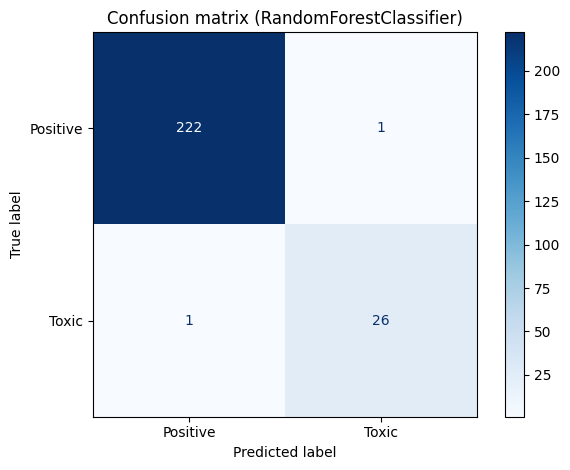

0    223
1     27
Name: toxic, dtype: int64

In [39]:
final_model.plot_confusion_matrix()
target_test.value_counts()

## Final conclusion

This project was devoted to the task of textual classification and determination of the toxicity of comments. During the execution of the project, the data was studied and encoded using embeddings. The subsequent procedure of selecting hyperparameters for a number of machine learning and gradient boosting models showed the success of the *Random Forest* model, which not only has the required quality, but is also adequate enough, which was noticeable by the high values of the *F1* and *AUC_ROC* metrics.